## Author: Aqib Aziz

### Project: Bone Fracture Detector
This model is implemented to process X-RAY images to detect fracture in bones.

In [1]:
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Model
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img

In [2]:
# Unzipping the dataset

# with ZipFile('drive/MyDrive/BoneFractureDataset.zip', 'r') as local_zip:
#   local_zip.extractall('drive/MyDrive')


### Bone X-ray Images data

In [3]:
train_dir = 'drive/MyDrive/boneimages/train'
valid_dir = 'drive/MyDrive/boneimages/val'

train_fractured_bones = os.path.join(train_dir, 'fractured')
train_notFractured_bones = os.path.join(train_dir, 'not fractured')

val_fractured_bones = os.path.join(valid_dir, 'fractured')
val_notFractured_bones = os.path.join(valid_dir, 'not fractured')

print(f"There are {len(os.listdir(train_fractured_bones))} fractured bone images for training.")
print(f"There are {len(os.listdir(train_notFractured_bones))} not-fractured bone images for training.")
print(f"There are {len(os.listdir(val_fractured_bones))} fractured bone images for validaton.")
print(f"There are {len(os.listdir(val_notFractured_bones))} not-fractured bone images for validation.")

There are 4480 fractured bone images for training.
There are 4383 not-fractured bone images for training.
There are 360 fractured bone images for validaton.
There are 240 not-fractured bone images for validation.


### Visualizing 2 images from dataset.

Sample fractured bone image:


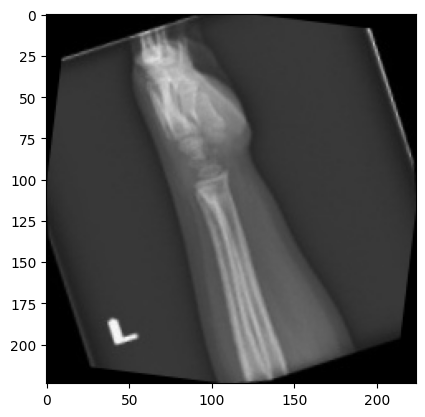


Sample not-fractured bone image:


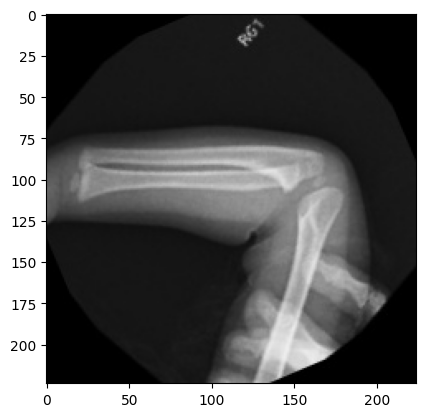

In [4]:
print("Sample fractured bone image:")
plt.imshow(load_img(f"{os.path.join(train_fractured_bones, os.listdir(train_fractured_bones)[0])}"))
plt.show()

print("\nSample not-fractured bone image:")
plt.imshow(load_img(f"{os.path.join(train_notFractured_bones, os.listdir(train_notFractured_bones)[0])}"))
plt.show()

### Checking shape of images in the dataset

In [5]:
# Load the first example of a fractured bone
image = load_img(f"{os.path.join(train_fractured_bones, os.listdir(train_fractured_bones)[0])}")

# Convert the image into its numpy array representation
array = img_to_array(image)

print(f"Each image has shape: {array.shape}")

Each image has shape: (224, 224, 3)


In [6]:
# Defining the hyperameters
img_width, img_height = 224,224
batch_size = 32
num_epochs = 10

### Training & Validation Generators

In [7]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator: tuple containing the generators
  """

  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator(rescale = 1/255)

   # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=batch_size,
                                                      class_mode='binary',
                                                      target_size=(img_width, img_height))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen =ImageDataGenerator(rescale = 1/255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=batch_size,
                                                                class_mode='binary',
                                                                target_size=(img_width, img_height))

  return train_generator, validation_generator

In [8]:
train_generator, validation_generator = train_val_generators(train_dir, valid_dir)

Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


### Using inceptionV3

In [9]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-07-22 14:05:27--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 142.251.111.128, 142.251.16.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   160MB/s    in 0.5s    

2023-07-22 14:05:27 (160 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [10]:
# Import the inception model
from keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [11]:
# Creating pre-trained Model
def create_pre_trained_model(local_weights_file):
  """
  Initializes an InceptionV3 model.

  Args:
    local_weights_file (string): path pointing to a pretrained weights H5 file

  Returns:
    pre_trained_model: the initialized InceptionV3 model
  """
  pre_trained_model = InceptionV3(input_shape = (img_width, img_height, 3),
                                  include_top = False,
                                  weights = None)

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

In [12]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [13]:
# output_of_last_layer
def output_of_last_layer(pre_trained_model):
  """
  Gets the last layer output of a model

  Args:
    pre_trained_model (tf.keras Model): model to get the last layer output from

  Returns:
    last_output: output of the model's last layer
  """

  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [14]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 12, 12, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 12, 12, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


### Build and compile the model

In [15]:
def create_final_model(pre_trained_model, last_output):
    """
    Appends a custom model to a pre-trained model

    Args:
        pre_trained_model (tf.keras Model): model that will accept the train/test inputs
        last_output (tensor): last layer output of the pre-trained model

    Returns:
        model: the combined model
    """
    # Flatten the output layer to 1 dimension
    x = layers.Flatten()(last_output)

    # Add a fully connected layer with 1024 hidden units and ReLU activation
    x = layers.Dense(1024, activation='relu')(x)
    # Add a dropout rate of 0.2
    x = layers.Dropout(0.2)(x)
    # Add a final sigmoid layer for classification
    x = layers.Dense(1, activation='sigmoid')(x)

    # Create the complete model by using the Model class
    model = Model(pre_trained_model.inputs, x)

    # Compile the model
    model.compile(
        optimizer=RMSprop(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [16]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 122,223,521 total parameters in this model.
There are 113,248,257 trainable parameters in this model.


#### Define a Callback class that stops training once accuracy reaches 99.9%

In [17]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

### Training the model

In [18]:
callbacks = myCallback()
history = model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/10
277/277 [==============================] - 1787s 6s/step - loss: 0.2936 - accuracy: 0.8908 - val_loss: 0.6717 - val_accuracy: 0.7867
Epoch 2/10
277/277 [==============================] - 1578s 6s/step - loss: 0.0594 - accuracy: 0.9848 - val_loss: 1.1692 - val_accuracy: 0.8050
Epoch 3/10
277/277 [==============================] - 1566s 6s/step - loss: 0.0204 - accuracy: 0.9942 - val_loss: 1.2958 - val_accuracy: 0.8267
Epoch 4/10
277/277 [==============================] - 1561s 6s/step - loss: 0.0129 - accuracy: 0.9962 - val_loss: 2.1595 - val_accuracy: 0.7950
Epoch 5/10
277/277 [==============================] - 1577s 6s/step - loss: 0.0060 - accuracy: 0.9981 - val_loss: 1.6109 - val_accuracy: 0.8250
Epoch 6/10
277/277 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.9991
Reached 99.9% accuracy so cancelling training!
277/277 [==============================] - 1568s 6s/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 1.7239 - val_accuracy: 0.7783


### Predicting Images

In [22]:
import numpy as np
from google.colab import files

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(img_width, img_height))

  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)

  images = np.vstack([x])   # for predicting multiple images at a time.
  classes = model.predict(images, batch_size=10)    # 10 images at once

  # classes = model.predict(x)  # for single image a time

  print(classes[0])

  if classes[0]<0.5:
    print(fn + " is a Fractured bone")
  else:
    print(fn + " is a Not-Fractured bone")

Saving leg13.jpg to leg13 (3).jpg
Saving leg12.jpg to leg12 (3).jpg
Saving leg11.jpg to leg11 (2).jpg
Saving leg10.jpg to leg10 (2).jpg
Saving leg8.jpg to leg8 (1).jpg
1/1 [==============================] - 0s 188ms/step
[9.203842e-07]
leg13 (3).jpg is a Fractured bone
1/1 [==============================] - 0s 183ms/step
[1.3666674e-07]
leg12 (3).jpg is a Fractured bone
1/1 [==============================] - 0s 169ms/step
[0.60352457]
leg11 (2).jpg is a Not-Fractured bone
1/1 [==============================] - 0s 173ms/step
[0.60352457]
leg10 (2).jpg is a Not-Fractured bone
1/1 [==============================] - 0s 166ms/step
[0.03163493]
leg8 (1).jpg is a Fractured bone
